In [1]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
# from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
def test_inds(dataset, dates=[], plot=True):
    import datetime
    if len(dates):
        dataset.get_sensor_features();
        df = pd.DataFrame(dataset.df_features['date'], columns=['date'])
        if plot:
            df.groupby([df["date"].dt.year, df["date"].dt.month, df['date'].dt.day]).count().plot(kind="bar", figsize=(14,4))
        lst = []
        for dt, sub in df.groupby([df["date"].dt.year, df["date"].dt.month, df['date'].dt.day]):
            if dt in dates:
                lst = lst + sub.index.tolist()
    print(len(lst))
    return np.array(lst)

In [3]:
data1 = Dataset('Leafminers')
data1.read(data=data1.target_classes[0], loadmat=False)
inds_1 = test_inds(data1, dates=[(2019,4,10),
                                 (2019,4,11),
                                 (2019,4,25),
                                 (2019,4,26),
                                 (2019,4,27),
                                 (2019,4,28),
                                 (2019,4,29),
                                 (2019,4,30), 
                                 (2019,5,2), 
                                 (2019,5,3)], plot=True);

Data: Chicorii.
Read 1451 filenames in 0.64 seconds.
238


Data: LG_drosophila_10_09.
Read 5536 filenames in 0.09 seconds.
476


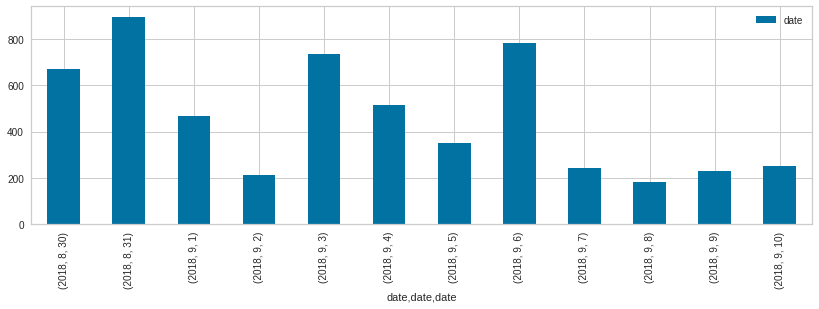

In [47]:
data2 = Dataset('LG')
data2.read(data=data2.target_classes[0], loadmat=False)
inds_2 = test_inds(data2, dates=[(2018,9,9), (2018,9,10)], plot=True);

Data: LG_zapr_26_09.
Read 7210 filenames in 0.09 seconds.
828


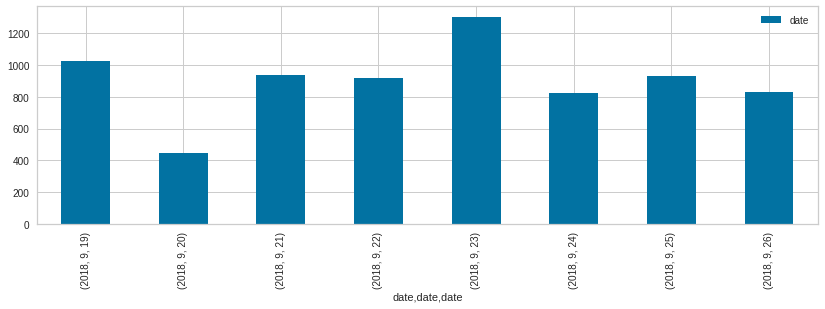

In [48]:
data3 = Dataset('LG')
data3.read(data=data3.target_classes[1], loadmat=False)
inds_3 = test_inds(data3, dates=[(2018,9,26)], plot=True);

Data: D. suzukii.
Read 8567 filenames in 0.10 seconds.
579


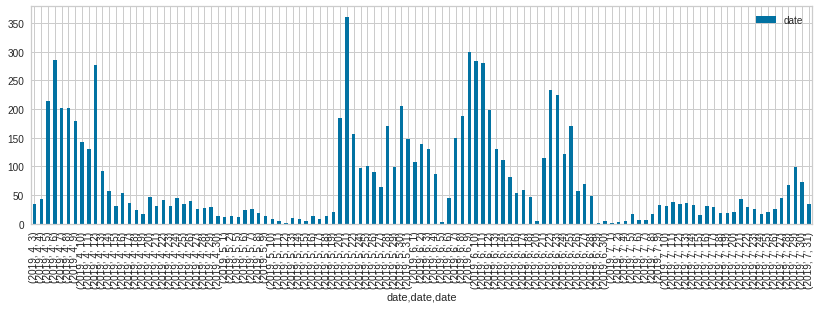

In [49]:
data4 = Dataset('Pcfruit')
data4.read(data=data4.target_classes[1], loadmat=False)
inds_4 = test_inds(data4, dates=[(2019,6,22),(2019,6,23),(2019,6,24)], plot=True);

## Creating TRAIN/VAL/TEST sets

In [50]:
def sub_test(dataset, inds):
    X = dataset.filenames.loc[~dataset.filenames.index.isin(inds)]
    y = dataset.y.loc[~dataset.y.index.isin(inds)]
    X_test = dataset.filenames.loc[dataset.filenames.index.isin(inds)]
    y_test = dataset.y.loc[dataset.y.index.isin(inds)]
    return X, y, X_test, y_test

x1, y1, xt1, yt1 = sub_test(data1, inds_1)
x2, y2, xt2, yt2 = sub_test(data2, inds_2)
x3, y3, xt3, yt3 = sub_test(data3, inds_3)
x4, y4, xt4, yt4 = sub_test(data4, inds_4)

In [51]:
X_test = pd.concat([xt1,xt2,xt3,xt4], axis=0).tolist()
y_test = pd.concat([yt1,yt2,yt3,yt4], axis=0).tolist()

In [52]:
X = pd.concat([x1,x2,x3,x4], axis=0).tolist()
y = pd.concat([y1,y2,y3,y4], axis=0).tolist()

df = pd.DataFrame({"X": X, "y":y})
# df.drop(index=df[df['y'] == 'Ae. aegypti'].sample(38345).index.values, inplace=True)
X,y = df.X.values, df.y.values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.fit_transform(y_test)

In [53]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X,y = shuffle(X,y, random_state=0)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
print(pd.Series(y_train).value_counts())
pd.Series(le.inverse_transform(y_train)).value_counts()
# y_train

1    6383
3    5095
2    4053
0     983
dtype: int64


D. suzukii             6383
LG_zapr_26_09          5095
LG_drosophila_10_09    4053
Cichorii                983
dtype: int64

In [76]:
df_train = make_df_parallel(setting='raw', names=X_train)
df_val = make_df_parallel(setting='raw', names=X_val)
df_test = make_df_parallel(setting='raw', names=X_test)

## XGBoost

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost
from utils import get_classifier

# clf_name = 'xgboost'
# classifier = get_classifier(clf_name)

import xgboost
classifier = xgboost.XGBClassifier(n_estimators=150, 
                                   learning_rate=0.2, 
                                   n_jobs=-1,
                                   class_weight={0:50., 1:1., 2:1., 3:1.},
                                   random_state=0)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))


Name: model, ac: 0.974540


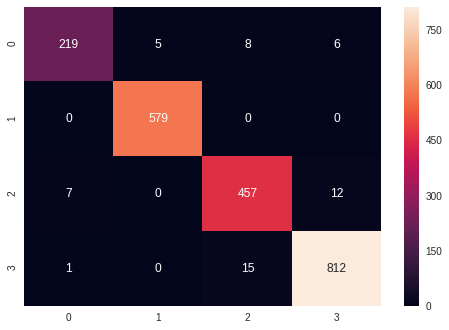

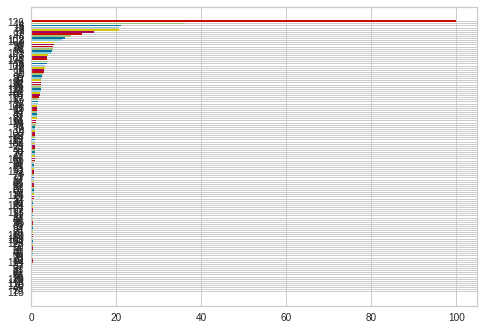

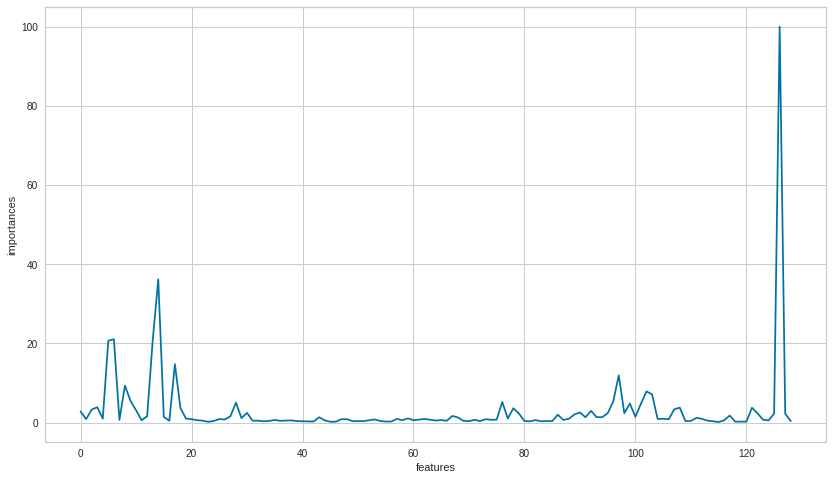

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

from yellowbrick.model_selection import FeatureImportances

model = classifier
viz = FeatureImportances(model);
viz.fit(df_test.values, y_test);

plt.figure(figsize=(14,8))
sub = pd.DataFrame(np.vstack((viz.features_,viz.feature_importances_))).T
sub.columns = ['features','importances']
sns.lineplot(x=sub.features, y=sub.importances)

## Random forest

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost
from utils import get_classifier

# clf_name = 'rf'
# classifier = get_classifier(clf_name)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, 
                                    n_jobs=-1, 
#                                     class_weight={0:50., 1:1., 2:1., 3:1.}, 
                                    random_state = 0)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))


Name: model, ac: 0.891089


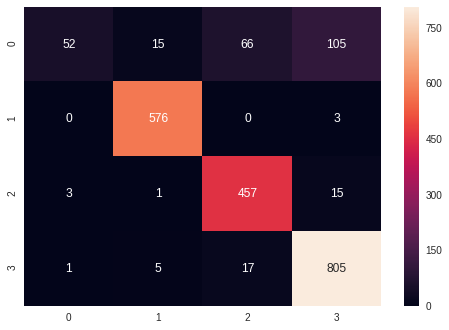

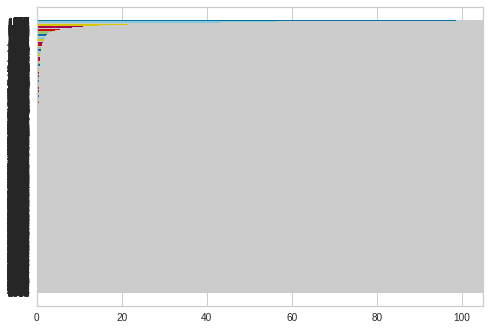

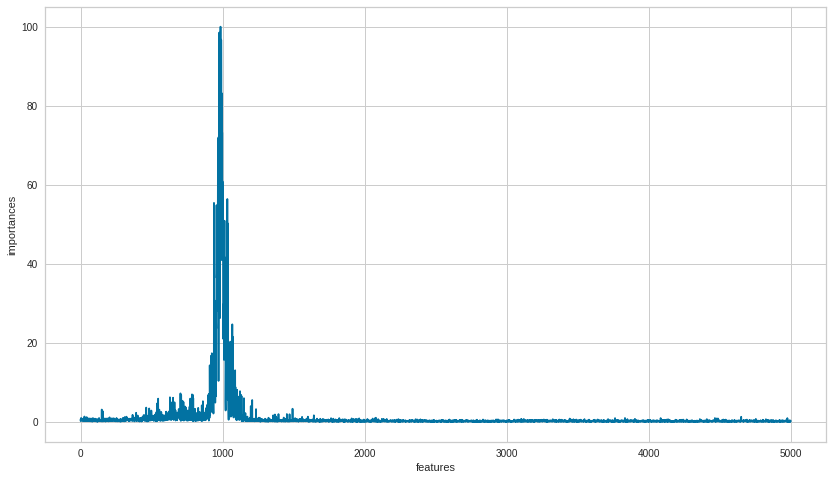

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

from yellowbrick.model_selection import FeatureImportances
model = classifier
viz = FeatureImportances(model);
viz.fit(df_test.values, y_test);

plt.figure(figsize=(14,8))
sub = pd.DataFrame(np.vstack((viz.features_,viz.feature_importances_))).T
sub.columns = ['features','importances']
sns.lineplot(x=sub.features, y=sub.importances)

In [79]:
pd.Series(le.inverse_transform(y_test)).value_counts()

LG_zapr_26_09          828
D. suzukii             579
LG_drosophila_10_09    476
Cichorii               238
dtype: int64

In [80]:
pd.Series(y_test).value_counts()

3    828
1    579
2    476
0    238
dtype: int64